In [77]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network. The net has an input dimension of
  N, a hidden layer dimension of H, and performs classification over C classes.
  We train the network with a softmax loss function and L2 regularization on the
  weight matrices. The network uses a ReLU nonlinearity after the first fully
  connected layer.

  In other words, the network has the following architecture:

  input - fully connected layer - ReLU - fully connected layer - softmax

  The outputs of the second fully-connected layer are the scores for each class.
  """
  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)     #初始化神经网络的参数

  def loss(self, X, y=None, reg=0.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network.

    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    #print(self.params['b2'])
    #print(X.shape)
    N, D = X.shape

    # Compute the forward pass
    scores = None
    #############################################################################
    # TODO: Perform the forward pass, computing the class scores for the input. #
    # Store the result in the scores variable, which should be an array of      #
    # shape (N, C).                                                             #
    #############################################################################
    h1=np.maximum(0,np.dot(X,W1)+b1)# 这里是做了一个RELU的activition function
    scores=np.dot(h1,W2)+b2
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################
    
    # If the targets are not given then jump out, we're done
    if y is None:
      return scores

    # Compute the loss
    loss = None
    #############################################################################
    # TODO: Finish the forward pass, and compute the loss. This should include  #
    # both the data loss and L2 regularization for W1 and W2. Store the result  #
    # in the variable loss, which should be a scalar. Use the Softmax           #
    # classifier loss. So that your results match ours, multiply the            #
    # regularization loss by 0.5                                                #
    #############################################################################
    scores_max = np.max(scores, axis=1, keepdims=True)  # (N,1)
    # Compute the class probabilities
    exp_scores = np.exp(scores - scores_max)  # (N,C)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # (N,C)
    # cross-entropy loss and L2-regularization
    correct_logprobs = -np.log(probs[range(N), y])  # (N,1)
    data_loss = np.sum(correct_logprobs) / N
    reg_loss = 0.5 * reg * np.sum(W1 * W1) + 0.5 * reg * np.sum(W2 * W2)
    loss = data_loss + reg_loss     #计算出误差
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    # Backward pass: compute gradients
    grads = {}
    #############################################################################
    # TODO: Compute the backward pass, computing the derivatives of the weights #
    # and biases. Store the results in the grads dictionary. For example,       #
    # grads['W1'] should store the gradient on W1, and be a matrix of same size #
    #############################################################################
    dscores = probs  # (N,C) 
    dscores[range(N), y] -= 1  #  这个是输出的误差敏感项也就是梯度的计算，具体可以看上面softmax 的计算
    dscores /= N
    # Backprop into W2 and b2
    dW2 = np.dot(h1.T, dscores)  # (H,C) BP算法的计算，下面同理
    db2 = np.sum(dscores, axis=0, keepdims=True)  # (1,C
    # Backprop into hidden layer
    dh1 = np.dot(dscores, W2.T)  # (N,H)
    # Backprop into ReLU non-linearity
    dh1[h1 <= 0] = 0
    # Backprop into W1 and b1
    dW1 = np.dot(X.T, dh1)  # (D,H)
    db1 = np.sum(dh1, axis=0, keepdims=True)  # (1,H)
    # Add the regularization gradient contribution
    dW2 += reg * W2
    dW1 += reg * W1
    grads['W1'] = dW1
    grads['b1'] = db1
    grads['W2'] = dW2
    grads['b2'] = db2
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this neural network using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO: Create a random minibatch of training data and labels, storing  #
      # them in X_batch and y_batch respectively.                             #
      #########################################################################
      sample_index = np.random.choice(num_train, batch_size, replace=True)
      X_batch = X[sample_index, :]  # (batch_size,D)
      y_batch = y[sample_index]  # (1,batch_size)

      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      #########################################################################
      # TODO: Use the gradients in the grads dictionary to update the         #
      # parameters of the network (stored in the dictionary self.params)      #
      # using stochastic gradient descent. You'll need to use the gradients   #
      # stored in the grads dictionary defined above.                         #
      #########################################################################
      print (grads['b2'])
      a=grads['b2'].reshape(-1)
      grads['b2']=a
      a = grads['b1'].reshape(-1)
      grads['b1'] = a
      grads['b1'].reshape(-1)
      v_W2 = - learning_rate * grads['W2']
      self.params['W2'] += v_W2
      self.params['b2']-=learning_rate * grads['b2']
      v_W1 =  - learning_rate * grads['W1']
      self.params['W1'] += v_W1
      v_b1 = - learning_rate * grads['b1']
      self.params['b1'] += v_b1   #对参数进行更新
      #########################################################################
      #                             END OF YOUR CODE                          #
      #########################################################################

      if verbose and it % 100 == 0:
        print ('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch)
        val_acc = (self.predict(X_val) == y_val)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.

    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.

    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    y_pred = None

    ###########################################################################
    # TODO: Implement this function; it should be VERY simple!                #
    ###########################################################################
    y_pred = None
    h1 = np.maximum(0,(np.dot(X, self.params['W1']) + self.params['b1']))
    scores = np.dot(h1, self.params['W2']) + self.params['b2']
    y_pred = np.argmax(scores, axis=1)
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return y_pred

In [25]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [69]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

#from cs231n.classifiers.neural_net import TwoLayerNet

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

In [63]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.68027204961e-08


In [64]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.0189654196061


In [65]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.561318e-09
b1 max relative error: 1.555470e-09
W2 max relative error: 3.440708e-09
b2 max relative error: 3.865091e-11


In [72]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


[[ 0.15603054 -0.08138037 -0.07465017]]
[[ 0.12361926 -0.14541154  0.02179229]]
[[ 0.09148949 -0.0717489  -0.01974059]]
[[ 0.06607759 -0.10907456  0.04299697]]
[[ 0.07690711 -0.09247824  0.01557113]]
[[ 0.05937653 -0.0728508   0.01347427]]
[[ 0.04386043 -0.06180846  0.01794803]]
[[ 0.04478333 -0.01446545 -0.03031789]]
[[ 0.03251864 -0.0533105   0.02079186]]
[[ 0.03028168 -0.03840677  0.00812509]]
[[ 0.0234685  -0.02924172  0.00577322]]
[[ 0.01806594 -0.02341183  0.00534589]]
[[ 0.01873584 -0.02218636  0.00345052]]
[[ 0.01479666 -0.01907133  0.00427468]]
[[ 0.01503457 -0.02433675  0.00930218]]
[[ 0.00780303 -0.01127112  0.0034681 ]]
[[ 0.01022428 -0.01596875  0.00574447]]
[[ 0.00963416 -0.0156615   0.00602733]]
[[ 0.00733196 -0.01577375  0.00844178]]
[[ 0.00715334 -0.01040621  0.00325287]]
[[ 0.00925393 -0.0099464   0.00069246]]
[[ 0.00942939 -0.00964039  0.00021101]]
[[ 0.00538561 -0.00873823  0.00335262]]
[[ 0.00915269 -0.01378584  0.00463315]]
[[ 0.0079658  -0.00771242 -0.00025337]]


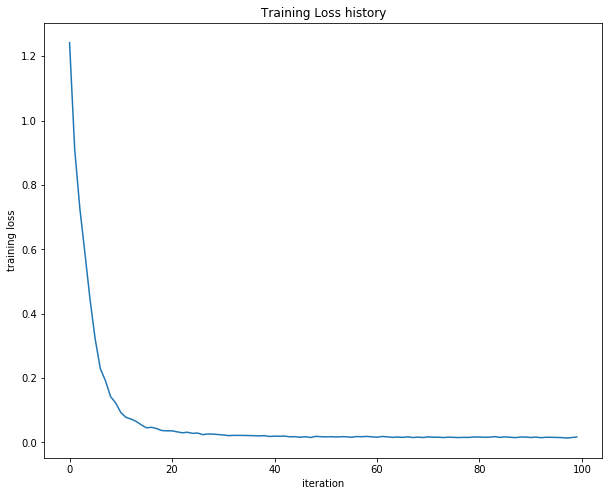

In [92]:
#train
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

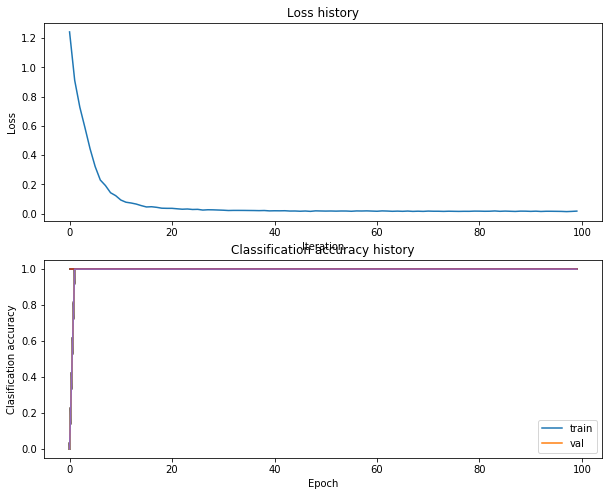

In [105]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'])
plt.plot(stats['val_acc_history'])
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
label = ["train","val"]
plt.legend(label)

plt.show()

(4, 10)


TypeError: Invalid dimensions for image data

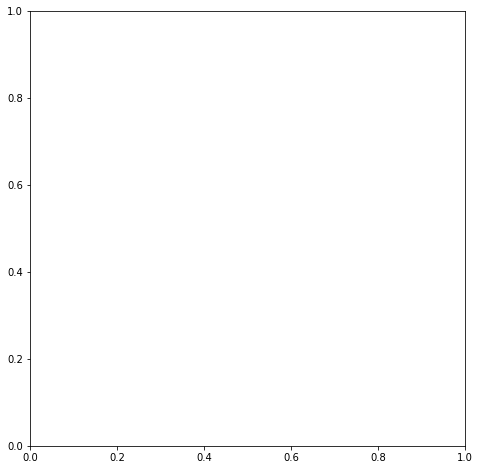

In [110]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network


#因为本例中没有用图片进行训练，所以无法对图片对应的特征图进行可视化。因为权重的shape大小是（4,10），无法reshape为（32,32,3，-1）
def show_net_weights(net):
    W1 = net.params['W1']
    print(W1.shape)
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)